### 적대적 예제 생성: FGSM(Fast Gradient Sign Attack)으로 mnist 분류기 속이기

- 위협 모델
    - 입력 데이터에 최소한의 작은 변화를 추가하여 의도적으로 잘못 분류되도록 하는 것
    - 공격자가 갖고 있는 정보: 화이트박스, 블랙박스
        - 화이트박스 공격: 공격자가 모델에 대해 아키텍처, 입력, 출력, 가중치 등의 정보를 모두 알고 있고 접근할 수 있다고 가정
        - 블랙박스 공격: 공격자가 모델의 입출력에만 접근가능하다고 가정

### FGSM(Fast Gradient Sign Attack)
- 화이트박스 공격
- 학습방식, 변화도(gradient)를 활용해 신경망 공격
- 역전파 변화도를 기반으로 가중치를 조정하여 손실을 최소화하기보다는 공격이 동일한 역전파 변화도를 기반으로 손실을 최대화하는 방향으로 입력 데이터를 조정
- 즉 공격은 입력 데이터에서 계산된 손실 변화도를 사용해 입력 데이터를 조정하여 손실이 최대가 되도록 함
![img](https://tutorials.pytorch.kr/_images/fgsm_panda_image.png)

- epsilon : 0~1의 값을 가짐. 0인 경우 testset에 대한 원래 ㅁ델의 성능을 나타냄


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: 아래는 MNIST 데이터셋을 내려받을 때 "User-agent" 관련한 제한을 푸는 코드입니다.
#       더 자세한 내용은 https://github.com/pytorch/vision/issues/3497 을 참고해주세요.
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = r"C:\Users\User\Desktop\study\DeepLearning_prac\pytorch_tutorial\pre_model\lenet_mnist_model.pth"
use_cuda=True


In [12]:
# LeNet 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
# dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),            
    ])),
    batch_size = 1, shuffle=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [13]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
device

CUDA Available:  True


device(type='cuda')

In [14]:
# 모델 초기화하기
model = Net().to(device)

# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSM 공격
- x(원본 이미지), e(엡실론, 픽셀 단위 변화 값), data_grad를 input으로 변화가 적용된 이미지 생성
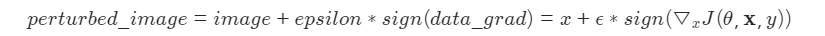

In [15]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성합니다
    perturbed_image = image + epsilon*sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

In [16]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

In [17]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

c:\Users\User\anaconda3\envs\pytorch_tutorial\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8509 / 10000 = 0.8509
Epsilon: 0.15	Test Accuracy = 6828 / 10000 = 0.6828
Epsilon: 0.2	Test Accuracy = 4300 / 10000 = 0.43
Epsilon: 0.25	Test Accuracy = 2080 / 10000 = 0.208
Epsilon: 0.3	Test Accuracy = 871 / 10000 = 0.0871


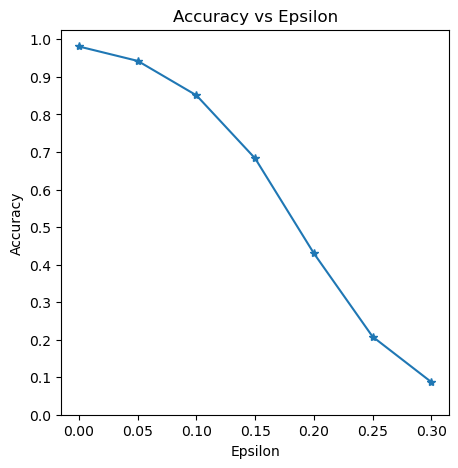

In [18]:
# 결과 시각화
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

- e가 커질수록 accuracy는 감소함. 그러나 그 관계가 선형은 아님
- e가 커질수록 정확도는 감소하나 작은 변화는 더 쉽게 인식할 수 있게 됨


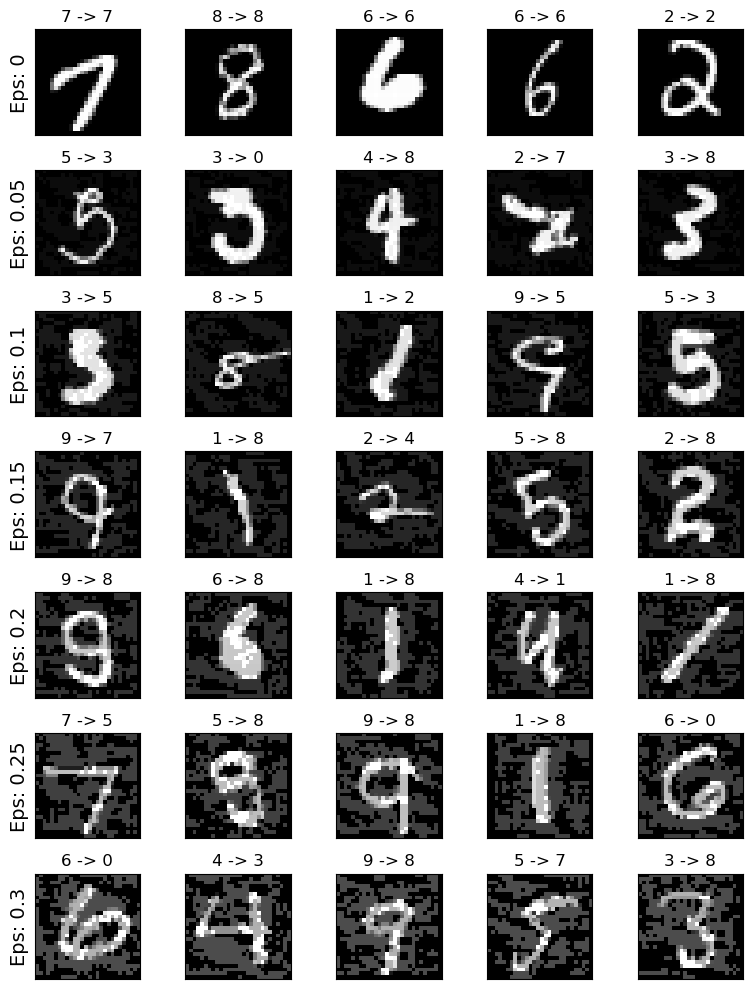

In [19]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()